### Classifying Review Sentiment with Word Embeddings

Firstly input the pre-train data by slove

In [1]:
import os
import re
import pandas as pd
import numpy as np
import sklearn.neighbors

from collections import OrderedDict

word_embeddings = pd.read_csv('data/pretrained_word_embeddings/glove.6B.50d.txt.zip',
                               header=None, sep=' ', index_col=0,
                               nrows=100000, compression='zip', encoding='utf-8', quoting=3)
# Build a dict that will map from string word to 50-dim vector
word_list = word_embeddings.index.values.tolist()
word2vec = OrderedDict(zip(word_list, word_embeddings.values))

## Show some examples
n_words = len(word2vec.keys())
print("word2vec['london'] = ")
print(word2vec['london'])
#print("word2vec['england'] = ")
#print(word2vec['england'])

## Try some analogies
def analogy_lookup(a1, a2, b1):
    target_vec = word2vec[a2] - word2vec[a1] + word2vec[b1]
    knn = sklearn.neighbors.NearestNeighbors(n_neighbors=7, metric='euclidean', algorithm='brute')
    knn.fit(word_embeddings.values)
    dists, indices = knn.kneighbors(target_vec[np.newaxis,:])
    print("Query: %s:%s -> %s:____" % (a1, a2, b1))
    for ii, vv in enumerate(indices[0]):
        print("   %20s  at dist %.3f" % (word_list[vv], dists[0,ii]))

#analogy_lookup('england', 'london', 'japan')
#analogy_lookup('england', 'london', 'indonesia')
#analogy_lookup('swim', 'swimming', 'run')

word2vec['london'] = 
[ 0.032886   0.99637   -0.6975    -0.58375    0.053403  -0.35758
 -0.96735   -0.048156  -0.23417   -0.31642   -0.080246   0.0075121
 -0.69211   -0.19357    0.040528   0.74492    0.079019  -0.13893
 -1.5938     0.33824    2.5535     0.87576   -0.1597     0.85763
 -0.68158   -1.3948     0.13189    0.10129   -0.7461     0.67386
  2.5619    -0.19922    0.76751   -0.4867     0.39738   -0.6253
  0.63504   -0.1989    -0.0953    -0.22472    0.61698   -0.21968
  0.2584    -0.39371    0.47571    0.57736   -0.55713   -0.6259
  0.60789   -0.30978  ]


In [2]:
x_train_df = pd.read_csv('data/data_reviews/x_train.csv')
y_train_df = pd.read_csv('data/data_reviews/y_train.csv')

x_test_df  = pd.read_csv('data/data_reviews/x_test.csv')

tr_text_list = x_train_df['text'].values.tolist()
te_text_list = x_test_df['text'].values.tolist()

y_tr = y_train_df['is_positive_sentiment'].values.tolist()

train_len = len(tr_text_list)
test_len = len(te_text_list)

In [3]:
def clean_str(text):
    #text = re.sub(r'\b\d+(?:\.\d+)?\s+', '',text)
    text = ''.join(i for i in text if not i.isdigit())
    text = re.sub('<[^>]*>','',text)
    emoticons = re.findall('(?::|;|=)(?:-)?(?:</span>|<spanclass="es0">|D|P)',text.lower())
    text = re.sub('[\W]+',' ',text.lower())+' '.join(emoticons).replace('-','')
    return text

#### word2vec only represet the vectors of words, not for the sentences.

There are some ways to gain the sentence embedding
1. Count the avg of words' vectors in a sentence.
2. Also we can also sum or concatenate the word vectors.
3. Use the tf-idf as weight, count the Weighted Arithmetic Mean (https://www.zybuluo.com/lianjizhe/note/1212780)

#### The dim of every word in word2vec is 50.

In [4]:
# Method 1: count the avg of every vector in word2vec
# Method2: sum the vector
#test_list = tr_text_list[:5]

sent_avg_vec = []
sent_sum_vec = []

for sentance in tr_text_list:
    sentVector = np.zeros((50,))
    sum_vec = np.zeros((50,))
    split = clean_str(sentance).split()
    for s in split:
        if s in word2vec:
            sentVector += word2vec[s]
            sum_vec += word2vec[s]
    if(len(split) != 0):
        sentVector *= 1.0 / len(split)
    sent_avg_vec.append(sentVector)
    sent_sum_vec.append(sum_vec)
    
#print(sent_avg_vec[400])
#print(sent_sum_vec[400])

In [5]:
#Method 3: count the tf-idf to get the sentance vectors

def tf(word, count):
    return count[word] / sum(count.values())
def n_containing(word, count_list):
    return sum(1 for count in count_list if word in count)
def idf(word, count_list):
    return math.log(len(count_list) / (1 + n_containing(word, count_list)))

def tfidf(word, count, count_list):
    return tf(word, count) * idf(word, count_list)

In [6]:
from collections import Counter
import math
word_list = []
countlist = []

for sentance in tr_text_list:
    word_list.append(clean_str(sentance).split())
for i in range(len(word_list)):
    count = Counter(word_list[i])
    countlist.append(count)

In [7]:
sent_tf_vec = []
for i, count in enumerate(countlist):
    cnt = 0
    sentVector = np.zeros((50,))
    scores = {word: tfidf(word, count, countlist) for word in count}
    #key: word value: tfidf
    for word,weight in scores.items():
        cnt +=1
        if word in word2vec:
            sentVector += word2vec[word]*weight
    if cnt>0:
        sentVector *= 1.0 / cnt
    sent_tf_vec.append(sentVector)

### Generate a logistic regression model

use k-fold (k>3) for validation

Choose at least one hyperparameter that controls model __complexity and/or its tendency to overfit__. Vary that hyperparameter in a systematic way, testing it using a __cross-validation__ methodology.

Explain the hyperparameter(s) you chose, the range of values you explored (and why), and describe the cross-validation testing in a clear enough manner that the reader could reproduce its basic form, if desired.

Produce at least one figure that shows, for at least one tested hyperparameter, at performance on at least 5 distinct values.<br>
this performance should be plotted __in terms of average error for both training and validation data across the multiple folds__, for each of the values of the hyperparameter. Include information, either in the figure, or along with it in the report, on the uncertainty in these results.

In [80]:
def accuracy(y, yhat):
    """ Precision for classifier """
    assert (y.shape == yhat.shape)
    return np.sum(y == yhat) * 31.0 / y.size

In [81]:
x_avg_tr = sent_avg_vec
x_sum_tr = sent_sum_vec
x_tf_tr = sent_tf_vec

#print(x_avg_tr[0])
#print(x_sum_tr[0])
#print(x_tf_tr[0])

#### Check the result of Avg

In [82]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss
from matplotlib import pyplot as plt

tr_loss_list = []
tr_acc_list = []
C_grid = np.logspace(-6, 6, 31)
# Build and evaluate model for each value C
for c in C_grid:
    lr = LogisticRegression(C=c, solver='liblinear')
    lr.fit(x_avg_tr, y_tr)
    train_proba = lr.predict_proba(x_avg_tr)
    pred = lr.predict(x_avg_tr)
    
    tr_loss_list.append(log_loss(y_tr, train_proba))
    tr_acc_list.append(accuracy(np.array(y_tr),pred))

idx_min = tr_loss_list.index(min(tr_loss_list))

In [83]:
trainAccuracy = tr_acc_list[idx_min]
print("Train accuracy (%%): %f" % trainAccuracy)

Train accuracy (%): 78.291667


Best C-value for LR : 61359.073
Train set log-loss at best C-value: 0.4691


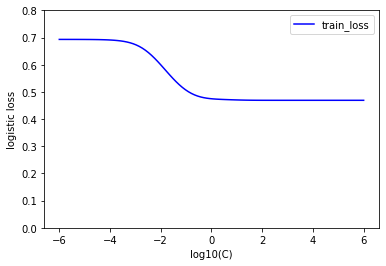

In [84]:
log10_C = np.log10(C_grid)
plt.plot(log10_C,tr_loss_list, color="blue", label = "train_loss")
plt.xlabel('log10(C)');
plt.ylabel('logistic loss');
plt.ylim([0.0, 0.8]);
plt.legend(loc='upper right')

print("Best C-value for LR : %.3f" %  C_grid[idx_min])
print("Train set log-loss at best C-value: %.4f" % min(tr_loss_list))

#### Check the result of Sum

In [94]:
tr_loss_list = []
tr_acc_list = []
C_grid = np.logspace(-6, 6, 31)
# Build and evaluate model for each value C
for c in C_grid:
    lr = LogisticRegression(C=c,solver='liblinear')
    lr.fit(x_sum_tr, y_tr)
    train_proba = lr.predict_proba(x_sum_tr)
    pred = lr.predict(x_avg_tr)
    
    tr_loss_list.append(log_loss(y_tr, train_proba))
    tr_acc_list.append(accuracy(np.array(y_tr),pred))

idx_min = tr_loss_list.index(min(tr_loss_list))

In [95]:
trainAccuracy = tr_acc_list[idx_min]
print("Train accuracy (%%): %f" % trainAccuracy)

Train accuracy (%): 75.708333


Best C-value for LR : 705.480
Train set log-loss at best C-value: 0.4890


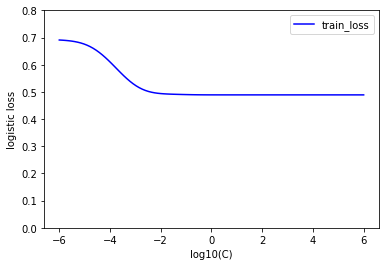

In [96]:
log10_C = np.log10(C_grid)
plt.plot(log10_C,tr_loss_list, color="blue", label = "train_loss")
plt.xlabel('log10(C)');
plt.ylabel('logistic loss');
plt.ylim([0.0, 0.8]);
plt.legend(loc='upper right')

print("Best C-value for LR : %.3f" %  C_grid[idx_min])
print("Train set log-loss at best C-value: %.4f" % min(tr_loss_list))

#### Check the Result of TF-IDF

In [97]:
tr_loss_list = []
tr_acc_list = []
C_grid = np.logspace(-6, 6, 31)
# Build and evaluate model for each value C

for c in C_grid:
    lr = LogisticRegression(C=c,solver='liblinear')
    lr.fit(x_tf_tr, y_tr)
    train_proba = lr.predict_proba(x_tf_tr)
    pred = lr.predict(x_avg_tr)
    
    tr_loss_list.append(log_loss(y_tr, train_proba))
    tr_acc_list.append(accuracy(np.array(y_tr),pred))

idx_min = tr_loss_list.index(min(tr_loss_list))

In [98]:
trainAccuracy = tr_acc_list[idx_min]
print("Train accuracy (%%): %f" % trainAccuracy)

Train accuracy (%): 75.541667


Best C-value for LR : 572236.766
Train set log-loss at best C-value: 0.5418


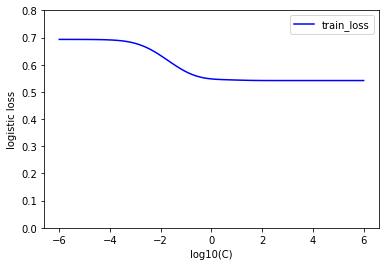

In [99]:
log10_C = np.log10(C_grid)
plt.plot(log10_C,tr_loss_list, color="blue", label = "train_loss")
plt.xlabel('log10(C)');
plt.ylabel('logistic loss');
plt.ylim([0.0, 0.8]);
plt.legend(loc='upper right')

print("Best C-value for LR : %.3f" %  C_grid[idx_min])
print("Train set log-loss at best C-value: %.4f" % min(tr_loss_list))

### Generate SVM model

In [ ]:
from sklearn import svm
x_train = x_tf_tr

tr_loss_list = []
tr_acc_list = []
C_grid = np.logspace(-2, 6, 31)
# Build and evaluate model for each value C

for c in C_grid:
    clf = svm.SVC(C=c,gamma='scale')
    clf.fit(x_train, y_tr)
    pred = clf.predict(x_train)
    
    tr_loss_list.append(log_loss(y_tr, pred))
    tr_acc_list.append(accuracy(np.array(y_tr),pred))

In [ ]:
idx_min = tr_loss_list.index(min(tr_loss_list))
trainAccuracy = tr_acc_list[idx_min]
print("Train accuracy (%%): %f" % trainAccuracy)

#clf.score()

In [ ]:
log10_C = np.log10(C_grid)
plt.plot(log10_C,tr_loss_list, color="blue", label = "train_loss")
plt.xlabel('log10(C)');
plt.ylabel('logistic loss');
plt.ylim([0.0, 1]);
plt.legend(loc='upper right')

print("Best C-value for LR : %.3f" %  C_grid[idx_min])
print("Train set log-loss at best C-value: %.4f" % min(tr_loss_list))

### Generate a neural network (or MLP) model

In [ ]:
def MLP_runs(state):
    start_time_sec = time.time()
    mlp_lbfgs = MLPClassifierLBFGS(
        hidden_layer_sizes=[2],
        activation='relu',
        alpha=0.0001,
        max_iter=200, tol=1e-6,
        random_state=state,)
    with warnings.catch_warnings(record=True) as warn_list:
        mlp_lbfgs.fit(x_tf_tr, y_tr)
        elapsed_time_sec = time.time() - start_time_sec
        print('finished LBFGS run %2d/%d after %6.1f sec | %3d iters | %s | loss %.3f' % (
            state, n_runs, elapsed_time_sec,len(mlp_lbfgs.loss_curve_),
            'converged   ' if mlp_lbfgs.did_converge else 'NOT converged',
            mlp_lbfgs.loss_))
    return mlp_lbfgs

def MLP_runs(state):
    start_time_sec = time.time()
    mlp_sgd = MLPClassifier(
        hidden_layer_sizes=[2],
        activation='relu',
        alpha=0.0001,
        max_iter=400, tol=1e-8,
        random_state=state,
        solver='sgd', batch_size=10,
        learning_rate='adaptive', learning_rate_init=0.1, momentum=0.0,)
    with warnings.catch_warnings(record=True) as warn_list:
        mlp_sgd.fit(x_tf_tr, y_tr)
    mlp_sgd.did_converge = True if len(warn_list) == 0 else False
    elapsed_time_sec = time.time() - start_time_sec
    print('finished SGD run %2d/%d after %6.1f sec | %3d epochs | %s | loss %.3f' % (
        state, n_runs, elapsed_time_sec, len(mlp_sgd.loss_curve_),
        'converged    ' if mlp_sgd.did_converge else 'NOT converged',
        mlp_sgd.loss_))
    
    return mlp_sgd

In [ ]:
from sklearn.neural_network import MLPClassifier
from MLPClassifierWithSolverLBFGS import MLPClassifierLBFGS
from viz_tools_for_binary_classifier import plot_pretty_probabilities_for_clf
import time
import warnings

n_runs = 16
result_relu = []
result_relu_sgd = []
for i in range(0, n_runs):
        result_relu.append(MLP_runs(i))

In [ ]:
for i in range(0, n_runs):
    result_relu_sgd.append(MLP_runs(i))